In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
class MLP(torch.nn.Module):
    def __init__(self, D_in=2, H=30, D_out=2):
        super(MLP, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, H)
        self.linear4 = torch.nn.Linear(H, D_out)

        torch.nn.init.constant_(self.linear1.bias, 0.)
        torch.nn.init.constant_(self.linear2.bias, 0.)
        torch.nn.init.constant_(self.linear3.bias, 0.)
        torch.nn.init.constant_(self.linear4.bias, 0.)

        torch.nn.init.normal_(self.linear1.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear2.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear3.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear4.weight, mean=0, std=0.1)

    def forward(self, x):
        y1 = torch.tanh(self.linear1(x))
        y2 = torch.tanh(self.linear2(y1))
        y3 = torch.tanh(self.linear3(y2))
        y = self.linear4(y3)
        u=y[:,0]
        v=y[:,1]
        return u.view(-1,1),v.view(-1,1)


In [2]:
L = 4
H = 1
t = -5 # point load
E = 1000 # Young modulus
v = 0.3 # Poisson ratio
c = 100
c1 = 630
c2 = -1.2
d = 2*(c1+2*c2)

def Fi(x, y):
    u, v = u_function(x, y)
    # 计算偏导数
    dX_dx = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0] + 1
    dX_dy = torch.autograd.grad(u, y, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    dY_dx = torch.autograd.grad(v, x, torch.ones_like(v), retain_graph=True, create_graph=True)[0]
    dY_dy = torch.autograd.grad(v, y, torch.ones_like(v), retain_graph=True, create_graph=True)[0] + 1

    detF = dX_dx * dY_dy - dX_dy * dY_dx
    C11 = dX_dx * dX_dx + dY_dx * dY_dx
    C12 = dX_dx * dX_dy + dY_dx * dY_dy
    C21 = dX_dy * dX_dx + dY_dy * dY_dx
    C22 = dX_dy * dX_dy + dY_dy * dY_dy
    J = detF
    traceC = C11 + C22
    I1 = traceC
    trace_C2 = C11 * C11 + C12 * C21 + C21 * C12 + C22 * C22
    I2 = 0.5 * (traceC ** 2 - trace_C2)
    fi = c * (J - 1) ** 2 - d * torch.log(J) + c1 * (I1 - 2) + c2 * (I2 - 1)
    return fi

def u_function(x,y):
    u, v = model(torch.hstack((x, y)))
    u = x * u
    v = x * v
    return u, v

def f_function(x, y, x_u, y_u):
    Fi_Nb = Fi(x, y)
    u_u, v_u = u_function(x_u, y_u)
    value = t * v_u
    f = L * H * torch.sum(Fi_Nb) / Fi_Nb.data.nelement()
    g = L * torch.sum(value) / value.data.nelement()

    return f - g
def Loss(x_f, y_f, x_u, y_u):
    ls = f_function(x_f, y_f, x_u, y_u)

    ls.backward()
    return ls

[Epoch 1/2000] [loss: 89.27800750732422]
[Epoch 201/2000] [loss: -16.61572265625]
[Epoch 401/2000] [loss: -14.618799209594727]
[Epoch 601/2000] [loss: -17.094329833984375]
[Epoch 801/2000] [loss: -17.107017517089844]
[Epoch 1001/2000] [loss: -17.108352661132812]
[Epoch 1201/2000] [loss: -17.109874725341797]
[Epoch 1401/2000] [loss: -17.11004638671875]
[Epoch 1601/2000] [loss: -17.11023712158203]
[Epoch 1801/2000] [loss: -17.11026382446289]


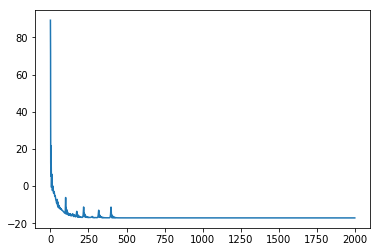

In [3]:
N1 = 200
N2 = 50
x = np.linspace(0,L,N1)
y = np.linspace(0,H,N2)
X, Y = np.meshgrid(x,y)

x_f = torch.tensor(X.reshape(-1,1), dtype=torch.float32, requires_grad=True)
y_f = torch.tensor(Y.reshape(-1,1), dtype=torch.float32, requires_grad=True)

x_right = np.ones((N2,1)) * L
y_right = np.linspace(0,H,N2).reshape(-1,1)

X_u_train = np.hstack((x_right,y_right))

x_u = torch.tensor(X_u_train[:,0].reshape(-1,1), dtype=torch.float32, requires_grad=True)
y_u = torch.tensor(X_u_train[:,1].reshape(-1,1), dtype=torch.float32, requires_grad=True)

model = MLP()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.1)
epochs = 2000
Losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = Loss(x_f, y_f, x_u, y_u)
    Losses.append(loss.item())
    if epoch % 200 ==0:
        print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item()}]")
    optimizer.step()
    scheduler.step()

plt.plot(Losses)
plt.show()

E:\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


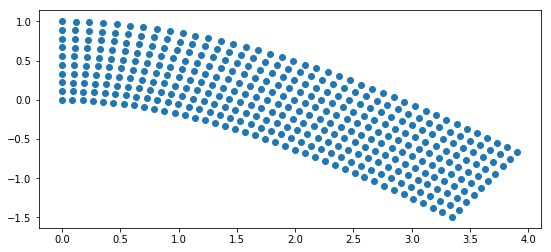

In [4]:
N1 = 40
N2 = 10
x = torch.linspace(0,L,N1)
y = torch.linspace(0,H,N2)
X, Y = torch.meshgrid(x,y)
X = X.reshape(-1,1)
Y = Y.reshape(-1,1)
plt.figure(figsize=(9,4))
u, v = u_function(X,Y)
xx = X + u
yy = Y + v
xnp = xx.detach().numpy()
ynp = yy.detach().numpy()
plt.scatter(xnp,ynp)
plt.show()